In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
from Bio import SeqIO
import numpy as np

from utils import setup_plotting_standards, basic_formatting
from itertools import islice
import requests

setup_plotting_standards()
COLOR = '#343434'

def batched(iterable, n):
    "Batch data into lists of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    it = iter(iterable)
    while True:
        batch = tuple(islice(it, n))
        if not batch:
            return
        yield batch

In [2]:
results = pd.read_csv( "substitutions/substitutions.csv" )
results.head()

,mutation,node,internal,lineage,ref,position,sub,sub_type
0,C40086A,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,C,40086,A,CA
1,A613113G,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,A,613113,G,AG
2,G1662874A,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,G,1662874,A,GA
3,G2630A,Africa|LBR|ERR998679|T9|1995-01-01,False,T9,G,2630,A,GA
4,A94336G,Africa|LBR|ERR998679|T9|1995-01-01,False,T9,A,94336,G,AG


In [4]:
ref = SeqIO.read( "../data/cholera_reference_NCBI.gb", "genbank" )

In [5]:
def get_info( reference_base, pos, substitution, reference ):
    pos_zero = pos - 1

    # Extract heptamer context (3 bases before, the base itself, 3 bases after)
    start_pos = max(0, pos_zero - 3)
    end_pos = min(len(reference), pos_zero + 4)
    heptamer = reference[start_pos:end_pos]

    # Find the gene containing this position
    gene_info = "intergenic"
    is_synonymous = "N/A"

    for feature in reference.features:
        if feature.type == "CDS":
            if pos_zero >= feature.location.start and pos_zero < feature.location.end:
                # get product information
                gene_name = feature.qualifiers.get("gene", ["Unknown"])[0]
                locus_tag = feature.qualifiers.get( "locus_tag", ["Unknown"] )[0]
                product = feature.qualifiers.get("product", ["Unknown"])[0]
                gene_info = f"{locus_tag}: {gene_name} ({product})"

                # Check if synonymous.
                relative_pos = pos_zero - feature.location.start
                codon_pos = relative_pos % 3
                codon_start = pos_zero - codon_pos

                if feature.location.strand == 1:
                    codon = reference[codon_start:codon_start+3]
                    # Create the mutated codon
                    mutated_codon = codon[:codon_pos] + substitution + codon[codon_pos+1:]
                    original_aa = str( codon.translate().seq )
                    mutated_aa = str( mutated_codon.translate().seq )
                else:
                    # For reverse strand, we need to take the complement
                    strand_pos = feature.location.end - relative_pos - 1
                    codon_pos_rev = strand_pos % 3
                    codon_start_rev = strand_pos - codon_pos_rev
                    codon_seq = reference[codon_start_rev:codon_start_rev+3]

                    # Create the mutated codon on the reverse strand
                    complement_map = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
                    rev_alt_base = complement_map[substitution]
                    rev_seq = reference[:pos] + rev_alt_base + reference[pos+1:]
                    mutated_codon_seq = rev_seq[codon_start_rev:codon_start_rev+3]

                    original_aa = str( codon_seq.reverse_complement().translate().seq )
                    mutated_aa = str( mutated_codon_seq.reverse_complement().translate().seq )

                if original_aa == mutated_aa:
                    is_synonymous = "Synonymous"
                else:
                    is_synonymous = f"Non-synonymous ({original_aa}->{mutated_aa})"

                annotated_result = {
                    "gene" : gene_info,
                    "locus_tag" : locus_tag,
                    "effect" : is_synonymous,
                    "heptamer_context" : heptamer,
                    "strand" : feature.location.strand,
                    "ref_aa" : original_aa,
                    "mutated_aa" : mutated_aa
                }

                return pd.Series( annotated_result )
    return None


aa_muts = results.apply( lambda x: get_info( x["ref"], x["position"], x["sub"], ref ), axis=1 )
aa_muts.head()

,gene,locus_tag,effect,heptamer_context,strand,ref_aa,mutated_aa
0,VC_0042: Unknown (potassium uptake protein TrkH),VC_0042,Synonymous,"(C, C, C, C, A, A, C)",-1.0,P,P
1,None,None,None,None,NaN,None,None
2,VC_1550: Unknown (glycerol-3-phosphate ABC tra...,VC_1550,Synonymous,"(T, C, T, G, C, T, G)",1.0,L,L
3,"VC_0004: Unknown (inner membrane protein, 60 kDa)",VC_0004,Synonymous,"(T, A, G, G, G, A, G)",-1.0,S,S
4,VC_0095: Unknown (chorismate--pyruvate lyase),VC_0095,Synonymous,"(T, A, G, A, G, T, A)",-1.0,I,I


In [6]:
results = pd.concat( [results, aa_muts], axis=1 )



In [7]:
lineages = ["background", "T9", "T10", "T11", "T12", "T13", "T15"]

results["mutation_type"] = "silent"
results.loc[results["ref_aa"]!=results["mutated_aa"],"mutation_type"] = "missense"
results.loc[(results["mutation_type"]=="missense")&(results["mutated_aa"]=="*"),"mutation_type"] = "nonsense"
results["is_synonymous"] = results["mutation_type"]=="silent"
mutation_types = results.pivot_table( index="mutation_type", columns="lineage", values="strand", aggfunc="count" )
mutation_types /= mutation_types.sum()
mutation_types = mutation_types.reindex( columns=lineages, index=["silent", "missense", "nonsense"] ).T
mutation_types

mutation_type,silent,missense,nonsense
lineage,,,
background,0.604310,0.374276,0.021414
T9,0.609848,0.363636,0.026515
T10,0.714433,0.264313,0.021255
T11,0.618677,0.354086,0.027237
T12,0.702911,0.282534,0.014555
T13,0.805142,0.192152,0.002706
T15,0.757785,0.231834,0.010381


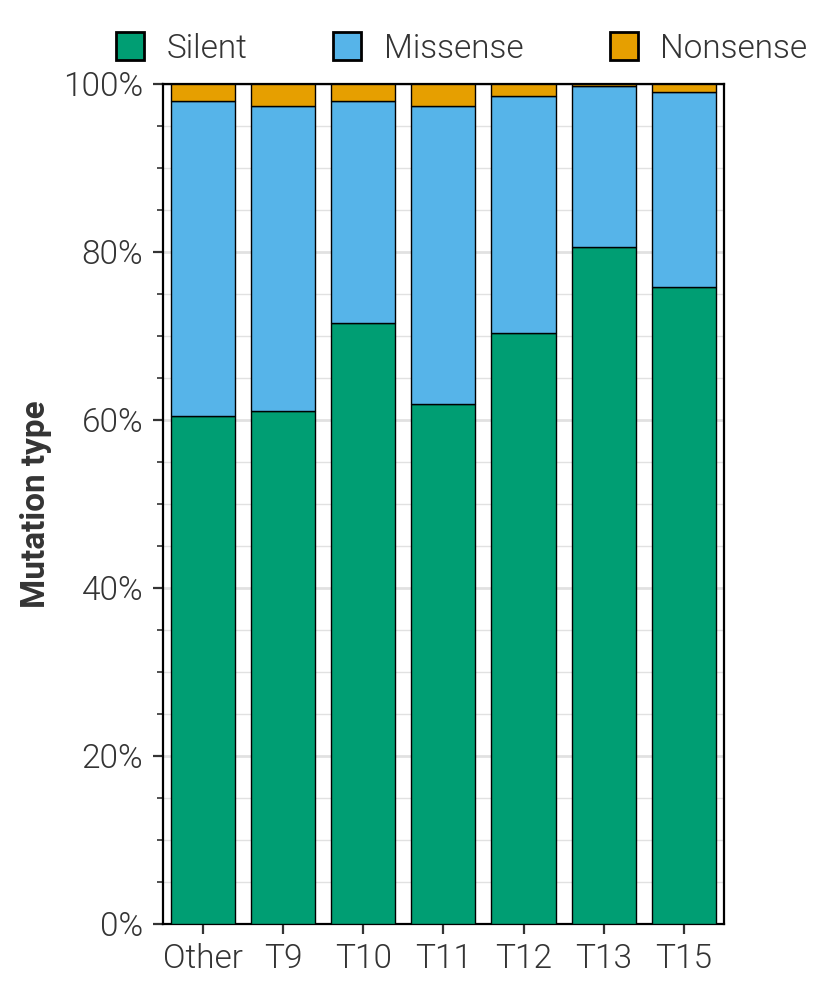

In [10]:
cmap = {
    "silent" : "#009E73",
    "missense" : "#56B4E9",
    "nonsense" : "#E69F00"
}

fig, ax = plt.subplots( dpi=200, figsize=(4,5) )
bottom = np.zeros( mutation_types.shape[0] )
legend = list()
for col in mutation_types.columns:
    ax.bar(x=range( mutation_types.shape[0] ), height=mutation_types[col], bottom=bottom, color=cmap[col], edgecolor="black", linewidth=0.5, zorder=50 )
    bottom += mutation_types[col]
    legend.append( Line2D([0], [0], linestyle='none', marker='s', color=cmap[col], markeredgecolor="black", markeredgewidth=1, label=col.title(), markersize=10 ), )

ax.set_yticks( np.arange(0,1.2,0.2), minor=False )
ax.set_yticks( np.arange(0,1,0.05), minor=True )
ax.set_ylim(0,1)
ax.set_ylabel( "Mutation type", fontweight="bold", fontsize=12 )

ax.set_xticks( range( mutation_types.shape[0] ), [i.replace( "background", "Other") for i in mutation_types.index]  )
ax.set_xlim(-0.5,6.5)

ax.yaxis.set_major_formatter( mticker.PercentFormatter(1))

ax.grid( axis="y", linewidth=1, color="#e1e1e1", zorder=1 )
ax.grid( axis="y", linewidth=0.5, which="minor", color="#e1e1e1", zorder=1 )

legend = fig.legend( handles=legend, loc="upper center", ncols=3, frameon=False, fontsize=12, handletextpad=0.1, bbox_to_anchor=[0.1,0,1,1.02] )

ax.tick_params( axis="both", labelsize=12 )

plt.tight_layout()
plt.savefig( "plots/figureS4-aa-mutation-profile.pdf", bbox_extra_artists=[legend], bbox_inches="tight" )
plt.show()

In [28]:
def get_taxon_id_panther( name ):
    supported_orgs_url = "https://pantherdb.org/services/oai/pantherdb/supportedgenomes"
    r = requests.post( supported_orgs_url )
    assert r.status_code == 200

    taxon_id = None
    for genome in r.json()["search"]["output"]["genomes"]["genome"]:
        if genome["name"] == "cholera":
            taxon_id = genome["taxon_id"]
            break
    assert taxon_id is not None, f"Unable to find genome for {name}"
    return taxon_id

tax_id = get_taxon_id_panther( "cholera" )

In [29]:
def handle_annotation(annotation):
    # Handle single annotation results that are occasionally not in list structures
    if isinstance(annotation, list):
        return annotation
    else:
        return [annotation]

def get_gene_info( genes, organism=243277 ):
    assert len( genes ) <= 1000

    dataset_title_mapping = {
        "GO:0008150": "go_bp_complete",
        "GO:0005575": "go_cc_complete",
        "GO:0003674": "go_mf_complete",
        "ANNOT_TYPE_ID_PANTHER_GO_SLIM_BP": "go_bp_slim",
        "ANNOT_TYPE_ID_PANTHER_GO_SLIM_CC": "go_cc_slim",
        "ANNOT_TYPE_ID_PANTHER_GO_SLIM_MF": "go_mf_slim",
        "ANNOT_TYPE_ID_PANTHER_PATHWAY": "panther_pathway",
        "ANNOT_TYPE_ID_REACTOME_PATHWAY": "reactome_pathway",
        "ANNOT_TYPE_ID_PANTHER_PC": "panther_protein_class"
    }

    gene_info_url = "https://pantherdb.org/services/oai/pantherdb/geneinfo"
    payload = {"geneInputList" : ",".join( genes ), "organism" : organism }

    r = requests.post( gene_info_url, data=payload )
    assert r.status_code == 200
    r = r.json()

    return_df = list()
    for gene_info in handle_annotation( r["search"]["mapped_genes"]["gene"] ):
        gene_entry = dict()
        for id_type in ["mapped_id_list", "family_id", "family_name", "sf_id", "sf_name", "accession"]:
            if id_type in gene_info:
                gene_entry[id_type] = gene_info[id_type]

        if "annotation_type_list" in gene_info:
            for annot in handle_annotation( gene_info["annotation_type_list"]["annotation_data_type"] ):
                try:
                    annotations = annot['annotation_list']['annotation']
                except TypeError:
                    print( gene_info )
                    raise

                go_terms = [a['id'] for a in handle_annotation( annotations )]

                if annot['content'] in dataset_title_mapping:
                    dataset_title = dataset_title_mapping[annot['content']]
                else:
                    dataset_title = annot['content']

                gene_entry[dataset_title] = go_terms

        return_df.append( gene_entry )

    return return_df

def batched_get_gene_info( genes, organism=243277, batch_size=500 ):
    df = list()
    for gene_set in batched( genes, batch_size ):
        batch_dfs = get_gene_info( gene_set, organism=organism )
        df.extend( batch_dfs )
    df = pd.DataFrame( df )
    return df

all_genes = results.loc[results["locus_tag"].notna(),"locus_tag"].unique()
gi = batched_get_gene_info( all_genes )
gi = gi.rename( columns={"family_id" : "panther_family_id", "family_name" : "panther_family_name", "sf_id" : "panther_subfamily_id", "sf_name" : "panther_subfamily_name", "accession" : "panther_accession"} )
res = results.merge( gi, left_on="locus_tag", right_on="mapped_id_list", how="left" )
res.head()

,mutation,node,internal,lineage,ref,position,sub,sub_type,gene,locus_tag,...,panther_subfamily_name,panther_accession,go_mf_complete,go_bp_complete,go_cc_complete,panther_protein_class,go_mf_slim,go_bp_slim,go_cc_slim,panther_pathway
0,C40086A,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,C,40086,A,CA,VC_0042: Unknown (potassium uptake protein TrkH),VC_0042,...,TRK SYSTEM POTASSIUM UPTAKE PROTEIN,VIBCH|EnsemblGenome=VC_0042|UniProtKB=Q9KVU7,"[GO:0008324, GO:0015079, GO:0015379, GO:0046872]","[GO:0006811, GO:0006812, GO:0006813, GO:003000...","[GO:0005886, GO:0016020]",NaN,NaN,NaN,NaN,NaN
1,A613113G,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,A,613113,G,AG,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G1662874A,Africa|LBR|ERR998678|T9|1995-01-01,False,T9,G,1662874,A,GA,VC_1550: Unknown (glycerol-3-phosphate ABC tra...,VC_1550,...,SN-GLYCEROL-3-PHOSPHATE TRANSPORT SYSTEM PERME...,VIBCH|EnsemblGenome=VC_1550|UniProtKB=Q9KRT6,NaN,[GO:0055085],"[GO:0005886, GO:0016020]",NaN,NaN,NaN,NaN,NaN
3,G2630A,Africa|LBR|ERR998679|T9|1995-01-01,False,T9,G,2630,A,GA,"VC_0004: Unknown (inner membrane protein, 60 kDa)",VC_0004,...,"CYTOCHROME C OXIDASE ASSEMBLY PROTEIN COX18, M...",VIBCH|EnsemblGenome=VC_0004|UniProtKB=Q9KVY4,"[GO:0003674, GO:0032977]","[GO:0008150, GO:0015031, GO:0051205]","[GO:0005886, GO:0016020]",[PC00227],NaN,[GO:0051205],NaN,NaN
4,A94336G,Africa|LBR|ERR998679|T9|1995-01-01,False,T9,A,94336,G,AG,VC_0095: Unknown (chorismate--pyruvate lyase),VC_0095,...,CHORISMATE PYRUVATE-LYASE,VIBCH|EnsemblGenome=VC_0095|UniProtKB=Q9KVP6,"[GO:0008813, GO:0016829]","[GO:0006744, GO:0042866]","[GO:0005737, GO:0005829]",[PC00144],[GO:0016830],[GO:0006744],[GO:0005829],NaN


In [30]:
def panther_overrepresentation_test( genes, dataset, organism=243277, correction="FDR" ):
    overrepresentation_url = "https://pantherdb.org/services/oai/pantherdb/enrich/overrep"
    payload = {"geneInputList" : ",".join( genes ), "organism" : organism, "annotDataSet" : dataset, "correction" : correction }
    r = requests.post( overrepresentation_url, data=payload )
    assert r.status_code == 200
    r = r.json()

    overrep_results = list()
    for test in r["results"]["result"]:
        if test["fold_enrichment"] > 0:
            temp = test
            temp["label"] = temp["term"]["label"]
            if "id" in temp["term"]:
                temp["id"] = temp["term"]["id"]
            del temp["term"]
            overrep_results.append( temp )
    overrep_results = pd.DataFrame( overrep_results )
    overrep_results["dataset"] = dataset
    return overrep_results

bio_overrep = list()
mol_overrep = list()
for lin in res["lineage"].unique():
    lin_genes = res.loc[(res["lineage"]==lin)&(res["locus_tag"].notna())&(~res["is_synonymous"]),"locus_tag"].unique()

    lin_bp_results =  panther_overrepresentation_test( lin_genes, dataset="GO:0008150" )
    lin_bp_results["lineage"] = lin
    bio_overrep.append( lin_bp_results )

    #GO:0003674
    lin_mf_results =  panther_overrepresentation_test( lin_genes, dataset="GO:0003674" )
    lin_mf_results["lineage"] = lin
    mol_overrep.append( lin_mf_results )

bio_overrep = pd.concat( bio_overrep, ignore_index=True )
bio_overrep["logfold_change"] = np.log2( bio_overrep["fold_enrichment"] )
bio_overrep["logpvalue"] = -np.log10( bio_overrep["pValue"] )
print( bio_overrep["lineage"].value_counts() )

lineage
background    1210
T10            882
T12            582
T9             533
T15            410
T13            390
T11            297
Name: count, dtype: int64


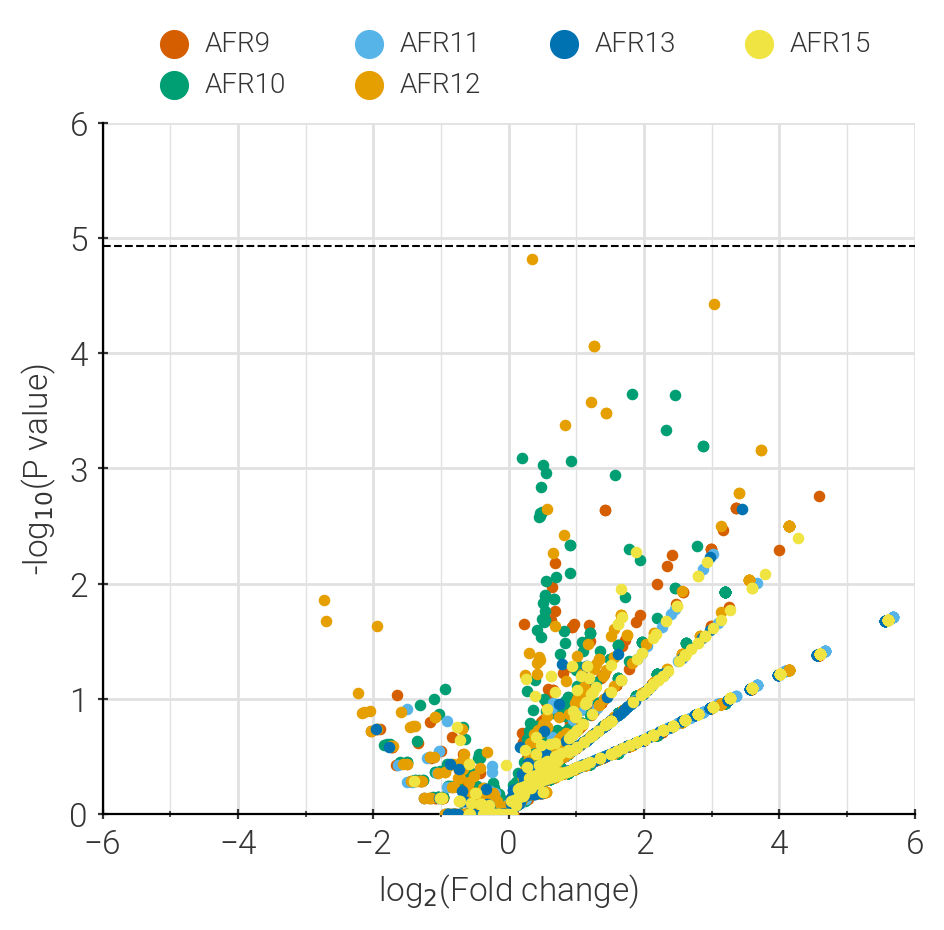

In [35]:
color_map = {
    "T9" : "#D55E00",
    "T10" : "#009E73",
    "T11": "#56B4E9",
    "T12": "#E69F00",
    "T13": "#0072B2",
    "T15" : "#F0E442",
    "background" : "#C8C8C8",
}
biosig = 0.05 / bio_overrep.shape[0]

fig, ax = plt.subplots( dpi=200, figsize=(5,5) )
for lin in color_map.keys():
    if lin == "background":
        continue
    points = bio_overrep.loc[bio_overrep["lineage"]==lin].plot( ax=ax, x="logfold_change", y="logpvalue", kind="scatter", s=10, label=lin.replace( "T", "AFR" ).replace( "background", "Other"), color=color_map[lin], zorder=100 )
    points.set_clip_on(False)

ax.axhline( -np.log10(biosig), color="black", linestyle="dashed", linewidth=0.75)

basic_formatting( ax, xlims=( -6,6 ), ylims=( 0, 6 ), xlabel="log$_{2}$(Fold change)", ylabel="-log$_{10}$(P value)" )

#ax.set_title( "Gene Ontology biological process", fontweight="bold" )
ax.legend( markerscale=3, frameon=False, ncols=4, fontsize=10, handletextpad=0.1, loc="upper center", bbox_to_anchor=(0,0,1,1.17) )

ax.set_xticks( range(-6,6,1), minor=True)

ax.grid( axis="both", linewidth=1, color="#e1e1e1", zorder=1 )
ax.grid( axis="both", linewidth=0.5, which="minor", color="#e1e1e1", zorder=1 )

plt.tight_layout()
fig.savefig( "plots/figureS4-geneset-enrichment.pdf" )
plt.show()